# **Market Analysis &ndash; Part 1**

This Notebook performs the computations and visualizations for the first part of the market analysis (customer preferences and issues) of our paper:

* Create sample of real product reviews that are about T-shirts
* Process the data from the manual market analysis
* Analysis of the manual market analysis
* Visualization of the results

## Preparation

In [1]:
# Import the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from math import sqrt

## Load the data

In [2]:
# Load the dataset
df = pd.read_parquet('Data/preprocessed_reviews.parquet')

# Display the first few rows
df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,datetime,date,language,label
560042,5.0,Love it,Ooo my God there are so cute high quality so c...,[],B07K5FNL9X,B07K5FNL9X,AGQUCGIIERAZ52YQLSIJ4QNHDXDA,1551003805448,0,True,2019-02-24 10:23:25.448,2019-02-24,en,1
376828,5.0,Very comfy,Love this. Fits true to size. The material doe...,[],B087M4NKRG,B087M4NKRG,AEFVJXNF2CTPMH2UNKKMR22XELMQ,1614024603205,0,True,2021-02-22 20:10:03.205,2021-02-22,en,1
1435908,5.0,Cute and flattering dress,This is a cute little dress that fits well. Fl...,[],B07QQC49R6,B07QQC49R6,AHKEQGFTKNC36VW2C7K2W6O5SE3Q,1601636010753,0,True,2020-10-02 10:53:30.753,2020-10-02,en,1
1125051,4.0,Four Stars,"I love this scarf! It's so pretty, I just wish...",[],B00KWHBEE2,B00KWHBEE2,AEXZ2S6245UH42FQTMEPP2SB56VA,1426944890000,0,True,2015-03-21 13:34:50.000,2015-03-21,en,1
1828865,5.0,Fit,Prefect fit and comfortable,[],B078NMRCND,B078NMRCND,AEKXJUDYXD6Y5Q3UI3FU6NOTAKMA,1584645783600,0,True,2020-03-19 19:23:03.600,2020-03-19,en,1


In [3]:
# Use a regex pattern to filter rows where any variation of "T-shirt" or "shirt" appears in either the 'title'

# Create a mask for the condition where any variation of "T-shirt" or "shirt" appears
mask = df['title'].str.contains(r'\bt[-]?shirt\b', case=False, na=False) | \
        df['title'].str.contains(r'\bshirt\b', case=False, na=False) 

# Filter the DataFrame based on the mask
filtered_df = df[mask]

# Display the filtered DataFrame
filtered_df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,datetime,date,language,label
222883,5.0,Great wine themed run shirt,Great shirt for wine themed run. Size measurem...,[],B01MSFQYPK,B01MRECDT9,AHZPEFGRGYB3J5YFUBYSHVSYWX3A,1562826539875,0,True,2019-07-11 06:28:59.875,2019-07-11,en,1
636935,4.0,I love the shirt and get compliments each time...,I love the shirt and get compliments each time...,[],B074TH49VM,B074TH49VM,AEXMM52LVUMJKJILTV7JF5G47YEQ,1510721770785,0,True,2017-11-15 04:56:10.785,2017-11-15,en,1
1612640,3.0,Not the shirt i ordered,We ordered this and a totally different shirt ...,[],B01LW09PWT,B01LW09PWT,AHJHXSPJFQTXO6IEYHVYH2FTA2IA,1484655384000,0,True,2017-01-17 12:16:24.000,2017-01-17,en,1
935608,5.0,A good inexpensive T shirt.,I haven’t washed it yet but I’m happy with the...,[],B0761148ZV,B0761148ZV,AHJQ2WIJFBERGPMEJEHSETOJKCUQ,1551482768912,0,True,2019-03-01 23:26:08.912,2019-03-01,en,1
1400311,5.0,Great team shirt.,Steelers are my favorite team. This shirt is t...,[],B09VPXP8JQ,B09VPXP8JQ,AHQZBJDXK7Y5534YHQDX4FYBXAUA,1664632810170,0,True,2022-10-01 14:00:10.170,2022-10-01,en,1


In [4]:
# Extract a 100 review sample from the real reviews for the market analysis 
sampled_text = filtered_df['text'].sample(n=100, random_state=42)

# Create a DataFrame with the index as the first column and the review as the second column
sampled_df = pd.DataFrame({
    'Index old': sampled_text.index,
    'Review': sampled_text.values
})

# Display the sampled DataFrame
sampled_df

,Index old,Review
0,916309,"Well made shirt, fits perfect"
1,1902242,I love this shirt! It fits great and perfect f...
2,1913440,"This is a nice denim shirt. It's cut ""slim"" bu..."
3,637615,Bought for my mom. She loves it!
4,654880,My son loves it. Got a size 5 for his 4th birt...
...,...,...
95,1619984,"It doesn't fit good in the shoulder and neck, ..."
96,1609773,Not a quality product not enough spandex feels...
97,2106303,"Ordered a XL, tag says XL, fits like a Medium!..."
98,939797,These pants are so cute! I got these for my 12...


In [5]:
# Save as CSV file
sampled_df.to_csv('real_reviews_human_evaluation.csv', index=False)

## Load the data

In [6]:
# Load the coded reviews from the different excel sheets
df_gpt2_rater1 = pd.read_excel('Data/market_analysis_rater1.xlsx', sheet_name='GPT-2 Market Analysis', dtype=str)
df_llama_rater1 = pd.read_excel('Data/market_analysis_rater1.xlsx', sheet_name='LLaMA 3 Market Analysis', dtype=str)
df_real_rater1 = pd.read_excel('Data/market_analysis_rater1.xlsx', sheet_name='Real Reviews Market Analysis', dtype=str)

df_gpt2_rater2 = pd.read_excel('Data/market_analysis_rater2.xlsx', sheet_name='GPT-2 Market Analysis', dtype=str)
df_llama_rater2 = pd.read_excel('Data/market_analysis_rater2.xlsx', sheet_name='LLaMA 3 Market Analysis', dtype=str)
df_real_rater2 = pd.read_excel('Data/market_analysis_rater2.xlsx', sheet_name='Real Reviews Market Analysis', dtype=str)

# Check one of the DataFrames
df_gpt2_rater1.head()

,Review,Code 1,Code 2,Code 3,Code 4,Code 5,Code 6,Code 7,Code 8,Code 9
0,I will buy my entire one on line. The quality ...,01,11,03,NaN,NaN,NaN,NaN,NaN,NaN
1,This thing is that it's made out of a plastic ...,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"After one use, the jacket is a little short. I...",14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,We are the RIPPING. We bought this for our 2 y...,1203,1201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,The shirt is absolutely adorable. It's not too...,01,03,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Processing

In [7]:
# Define a function to process each DataFrame
def process_dataframe(df):
    # Combine the columns 'Code 1' to 'Code 9' into a new column 'Combined Code'
    df['Combined Code'] = df[['Code 1', 'Code 2', 'Code 3', 'Code 4', 'Code 5', 'Code 6', 'Code 7', 'Code 8', 'Code 9']] \
        .apply(lambda row: [code for code in row if pd.notna(code)], axis=1)

    # Drop the 'Code 1' to 'Code 9' columns
    df.drop(columns=[f'Code {i}' for i in range(1, 10)], inplace=True)

    return df

# List of all DataFrames to process
dataframes = [df_gpt2_rater1, df_llama_rater1, df_real_rater1, df_gpt2_rater2, df_llama_rater2, df_real_rater2]

# Apply the function to each DataFrame in the list
for df in dataframes:
    process_dataframe(df)

In [8]:
# Define a function to normalize and compare DataFrames
def create_comparison_df(df_rater1, df_rater2):
    # Normalize 'Combined Code' by converting each list to a sorted tuple
    df_rater1['Normalized Code'] = df_rater1['Combined Code'].apply(lambda x: tuple(sorted(x)))
    df_rater2['Normalized Code'] = df_rater2['Combined Code'].apply(lambda x: tuple(sorted(x)))

    # Create a new DataFrame with 'Review', 'Rater1', 'Rater2', and 'Comparison' columns
    comparison_df = pd.DataFrame({
        'Review': df_rater1['Review'],
        'Rater1': df_rater2['Combined Code'],
        'Rater2': df_rater2['Combined Code'],
        'Comparison': df_rater1['Normalized Code'] == df_rater2['Normalized Code']
    })

    return comparison_df

# Create the comparison DataFrames for each pair
df_gpt2 = create_comparison_df(df_gpt2_rater1, df_gpt2_rater2)
df_llama = create_comparison_df(df_llama_rater1, df_llama_rater2)
df_real = create_comparison_df(df_real_rater1, df_real_rater2)

In [9]:
# Define a function to calculate code frequencies for all possible categories 
def calculate_code_frequencies(df):
    # Combine all lists from Rater 1 and Rater 2 columns into one Series
    all_codes = pd.Series(df['Rater1'].sum() + df['Rater2'].sum())
    
    # Use value_counts() to get the frequency of each code
    code_frequencies = all_codes.value_counts().reset_index()
    
    # Rename the columns for better understanding
    code_frequencies.columns = ['Code', 'Frequency']
    
    return code_frequencies

# Calculate code frequencies for each DataFrame
code_frequencies_gpt2 = calculate_code_frequencies(df_gpt2)
code_frequencies_llama = calculate_code_frequencies(df_llama)
code_frequencies_real = calculate_code_frequencies(df_real)

## Cosine similarity

In [10]:
# Merge DataFrames on Code to align frequencies
merged_df = pd.merge(code_frequencies_real, code_frequencies_gpt2, on='Code', how='outer', suffixes=('_df1', '_df2'))

# Replace NaN with 0 for frequencies
merged_df.fillna(0, inplace=True)

# Convert frequencies to integers
merged_df['Frequency_df1'] = merged_df['Frequency_df1'].astype(int)
merged_df['Frequency_df2'] = merged_df['Frequency_df2'].astype(int)

# Calculate dot product
dot_product = sum(merged_df['Frequency_df1'] * merged_df['Frequency_df2'])

# Calculate magnitudes
magnitude1 = sqrt(sum(merged_df['Frequency_df1'] ** 2))
magnitude2 = sqrt(sum(merged_df['Frequency_df2'] ** 2))

# Calculate cosine similarity
cosine_similarity = dot_product / (magnitude1 * magnitude2)
cosine_similarity

0.7267648309953141

In [11]:
# Merge DataFrames on Code to align frequencies
merged_df = pd.merge(code_frequencies_real, code_frequencies_llama, on='Code', how='outer', suffixes=('_df1', '_df2'))

# Replace NaN with 0 for frequencies
merged_df.fillna(0, inplace=True)

# Convert frequencies to integers
merged_df['Frequency_df1'] = merged_df['Frequency_df1'].astype(int)
merged_df['Frequency_df2'] = merged_df['Frequency_df2'].astype(int)

# Calculate dot product
dot_product = sum(merged_df['Frequency_df1'] * merged_df['Frequency_df2'])

# Calculate magnitudes
magnitude1 = sqrt(sum(merged_df['Frequency_df1'] ** 2))
magnitude2 = sqrt(sum(merged_df['Frequency_df2'] ** 2))

# Calculate cosine similarity
cosine_similarity = dot_product / (magnitude1 * magnitude2)
cosine_similarity

0.38449299752275484

In [12]:
# Merge DataFrames on Code to align frequencies
merged_df = pd.merge(code_frequencies_gpt2, code_frequencies_llama, on='Code', how='outer', suffixes=('_df1', '_df2'))

# Replace NaN with 0 for frequencies
merged_df.fillna(0, inplace=True)

# Convert frequencies to integers
merged_df['Frequency_df1'] = merged_df['Frequency_df1'].astype(int)
merged_df['Frequency_df2'] = merged_df['Frequency_df2'].astype(int)

# Calculate dot product
dot_product = sum(merged_df['Frequency_df1'] * merged_df['Frequency_df2'])

# Calculate magnitudes
magnitude1 = sqrt(sum(merged_df['Frequency_df1'] ** 2))
magnitude2 = sqrt(sum(merged_df['Frequency_df2'] ** 2))

# Calculate cosine similarity
cosine_similarity = dot_product / (magnitude1 * magnitude2)
cosine_similarity

0.6688579145747768

## Check the top categories

In [13]:
# Filter the top ten codes by frequency
code_frequencies_gpt2_topten = code_frequencies_gpt2.nlargest(10, 'Frequency')
code_frequencies_llama_topten = code_frequencies_llama.nlargest(10, 'Frequency')
code_frequencies_real_topten = code_frequencies_real.nlargest(10, 'Frequency')

# Display the resulting DataFrame with the top ten codes
code_frequencies_gpt2_topten

,Code,Frequency
0,14,52
1,0203,42
2,07,34
3,03,34
4,05,26
5,01,22
6,1201,20
7,06,20
8,09,20
9,04,14


In [14]:
# Use just the main categories

# Define a function to calculate code frequencies with modified strings
def calculate_code_frequencies_main_categories(df):
    # Combine all lists from 'Rater1' and 'Rater2' columns into one Series
    all_codes = pd.Series(df['Rater1'].sum() + df['Rater2'].sum())
    
    # Modify strings: use first 2 characters for lengths 2 or 4, first 3 for lengths 3 or 5
    modified_codes = all_codes.apply(lambda x: x[:2] if len(x) in [2, 4] else x[:3])

    # Use value_counts() to get the frequency of each code
    code_frequencies = modified_codes.value_counts().reset_index()
    
    # Rename the columns for better understanding
    code_frequencies.columns = ['Code', 'Frequency']
    
    return code_frequencies

# Calculate code frequencies for each DataFrame
code_frequencies_gpt2_main = calculate_code_frequencies_main_categories(df_gpt2)
code_frequencies_llama_main = calculate_code_frequencies_main_categories(df_llama)
code_frequencies_real_main = calculate_code_frequencies_main_categories(df_real)

In [15]:
# Filter the top ten main codes by frequency
code_frequencies_gpt2_topten_main = code_frequencies_gpt2_main.nlargest(10, 'Frequency')
code_frequencies_llama_topten_main = code_frequencies_llama_main.nlargest(10, 'Frequency')
code_frequencies_real_topten_main = code_frequencies_real_main.nlargest(10, 'Frequency')

# Display the resulting DataFrame with the top ten codes
code_frequencies_gpt2_topten_main

,Code,Frequency
0,02,102
1,12,72
2,14,52
3,03,34
4,07,34
5,05,26
6,01,22
7,06,20
8,09,20
9,11,16


## Visualizations

In [16]:
# Fixed layout parameters
left_margin = 0.1
right_margin = 0.9
top_margin = 0.8
bottom_margin = 0.4

C:\Users\Valentin Velev\AppData\Local\Temp\ipykernel_29464\3324759104.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns_barplot = sns.barplot(x='Code', y='Frequency', data=code_frequencies_gpt2_topten, palette=custom_colors)


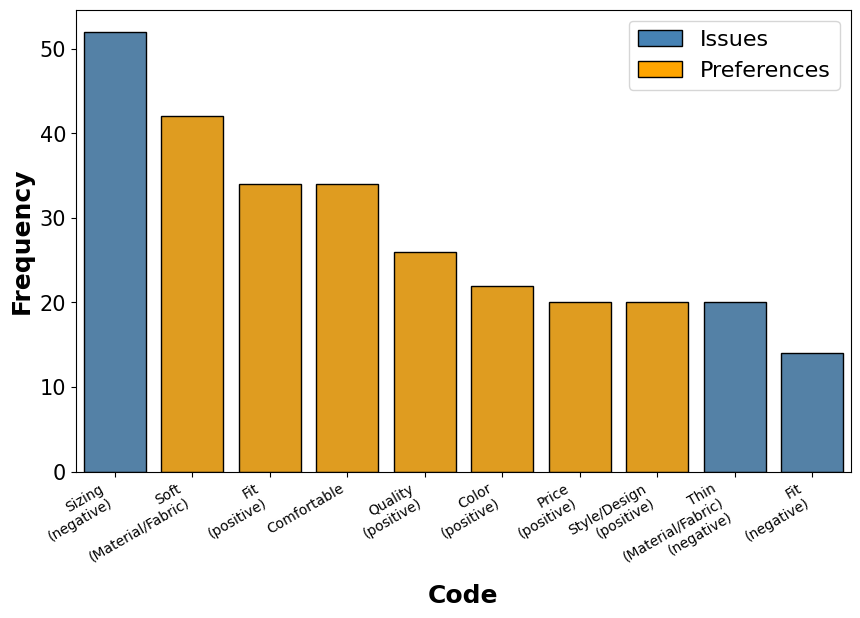

In [17]:
# Plot GPT-2 all categories
plt.figure(figsize=(10, 6))
# Define custom colors using valid color names or hex codes
custom_colors = ['steelblue', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'steelblue', 'steelblue']

sns_barplot = sns.barplot(x='Code', y='Frequency', data=code_frequencies_gpt2_topten, palette=custom_colors)
for bar in sns_barplot.patches:
    bar.set_edgecolor('black')  # Set the border color
    bar.set_linewidth(1)        # Set the border thickness

# Manually add custom labels to the bars
custom_labels = ['Sizing\n(negative)', 'Soft\n(Material/Fabric)', 'Fit\n(positive)', 'Comfortable', 'Quality\n(positive)', 'Color\n(positive)', 'Price\n(positive)', 'Style/Design\n(positive)', 'Thin\n(Material/Fabric)\n(negative)', 'Fit\n(negative)']
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, fontsize=10, rotation=30, ha='right')

# Add custom legend
legend_elements = [Patch(facecolor='steelblue', edgecolor='black', label='Issues'), Patch(facecolor='orange', edgecolor='black', label='Preferences')]
plt.legend(handles=legend_elements, loc='upper right', fontsize=16)

plt.xlabel('Code', weight='bold', fontsize=18)
plt.ylabel('Frequency', weight='bold', fontsize=18)
plt.yticks(fontsize=15)

# Manually adjust the layout
#plt.subplots_adjust(left=left_margin, right=right_margin, top=top_margin, bottom=bottom_margin)

plt.savefig('gpt-2_all_codes.pdf', format='pdf', dpi=1500, bbox_inches='tight')
plt.show()

C:\Users\Valentin Velev\AppData\Local\Temp\ipykernel_29464\1570984036.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns_barplot = sns.barplot(x='Code', y='Frequency', data=code_frequencies_gpt2_topten_main, palette=custom_colors)


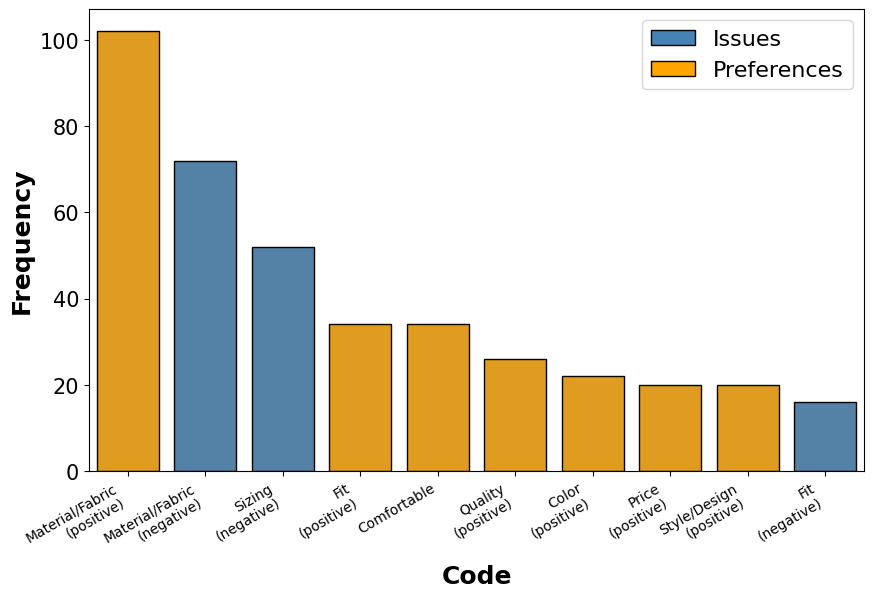

In [18]:
# Plot GPT-2 main categories
plt.figure(figsize=(10, 6))
# Define custom colors using valid color names or hex codes
custom_colors = ['orange', 'steelblue', 'steelblue', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'steelblue'] 

sns_barplot = sns.barplot(x='Code', y='Frequency', data=code_frequencies_gpt2_topten_main, palette=custom_colors)
for bar in sns_barplot.patches:
    bar.set_edgecolor('black')  # Set the border color
    bar.set_linewidth(1)        # Set the border thickness

# Manually add custom labels to the bars
custom_labels = ['Material/Fabric\n(positive)', 'Material/Fabric\n(negative)', 'Sizing\n(negative)', 'Fit\n(positive)', 'Comfortable', 'Quality\n(positive)', 'Color\n(positive)', 'Price\n(positive)', 'Style/Design\n(positive)', 'Fit\n(negative)']
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, fontsize=10, rotation=30, ha='right')

# Add custom legend
legend_elements = [Patch(facecolor='steelblue', edgecolor='black', label='Issues'), Patch(facecolor='orange', edgecolor='black', label='Preferences')]
plt.legend(handles=legend_elements, loc='upper right', fontsize=16)

plt.xlabel('Code', weight='bold', fontsize=18)
plt.ylabel('Frequency', weight='bold', fontsize=18)
plt.yticks(fontsize=15)

# Manually adjust the layout
#plt.subplots_adjust(left=left_margin, right=right_margin, top=top_margin, bottom=bottom_margin)

plt.savefig('gpt-2_main_codes.pdf', format='pdf', dpi=1500, bbox_inches='tight')
plt.show()

C:\Users\Valentin Velev\AppData\Local\Temp\ipykernel_29464\1519218480.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns_barplot = sns.barplot(x='Code', y='Frequency', data=code_frequencies_llama_topten, palette=custom_colors)


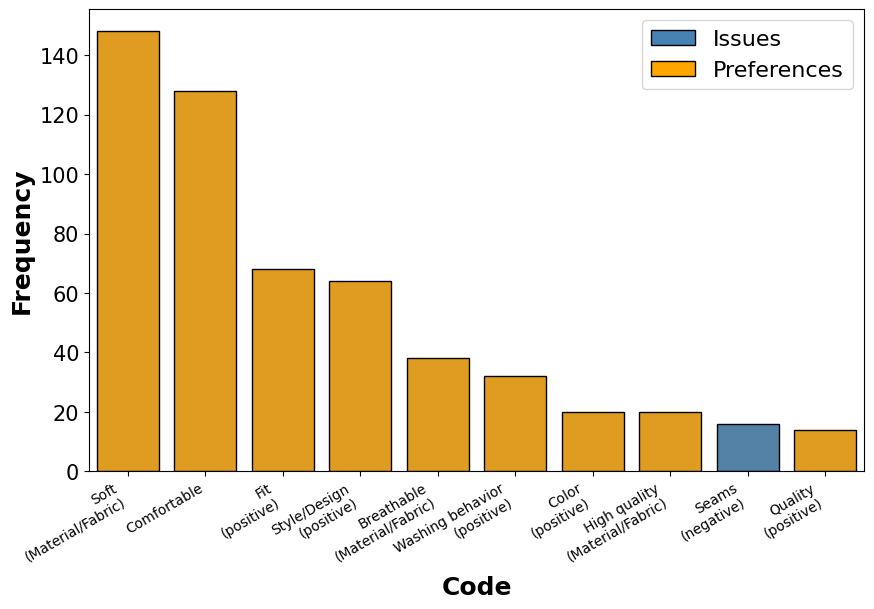

In [19]:
# Plot LLaMA 3 all categories
plt.figure(figsize=(10, 6))
# Define custom colors using valid color names or hex codes
custom_colors = ['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'steelblue', 'orange']

sns_barplot = sns.barplot(x='Code', y='Frequency', data=code_frequencies_llama_topten, palette=custom_colors)
for bar in sns_barplot.patches:
    bar.set_edgecolor('black')  # Set the border color
    bar.set_linewidth(1)        # Set the border thickness

# Manually add custom labels to the bars
custom_labels = ['Soft\n(Material/Fabric)', 'Comfortable', 'Fit\n(positive)', 'Style/Design\n(positive)', 'Breathable\n(Material/Fabric)', 'Washing behavior\n(positive)', 'Color\n(positive)', 'High quality\n(Material/Fabric)', 'Seams\n(negative)', 'Quality\n(positive)']
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, fontsize=10, rotation=30, ha='right')

# Add custom legend
legend_elements = [Patch(facecolor='steelblue', edgecolor='black', label='Issues'), Patch(facecolor='orange', edgecolor='black', label='Preferences')]
plt.legend(handles=legend_elements, loc='upper right', fontsize=16)

plt.xlabel('Code', weight='bold', fontsize=18)
plt.ylabel('Frequency', weight='bold', fontsize=18)
plt.yticks(fontsize=15)

# Manually adjust the layout
#plt.subplots_adjust(left=left_margin, right=right_margin, top=top_margin, bottom=bottom_margin)

plt.savefig('llama-3_all_codes.pdf', format='pdf', dpi=1500, bbox_inches='tight') 
plt.show()

C:\Users\Valentin Velev\AppData\Local\Temp\ipykernel_29464\617400130.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns_barplot = sns.barplot(x='Code', y='Frequency', data=code_frequencies_llama_topten_main, palette=custom_colors)


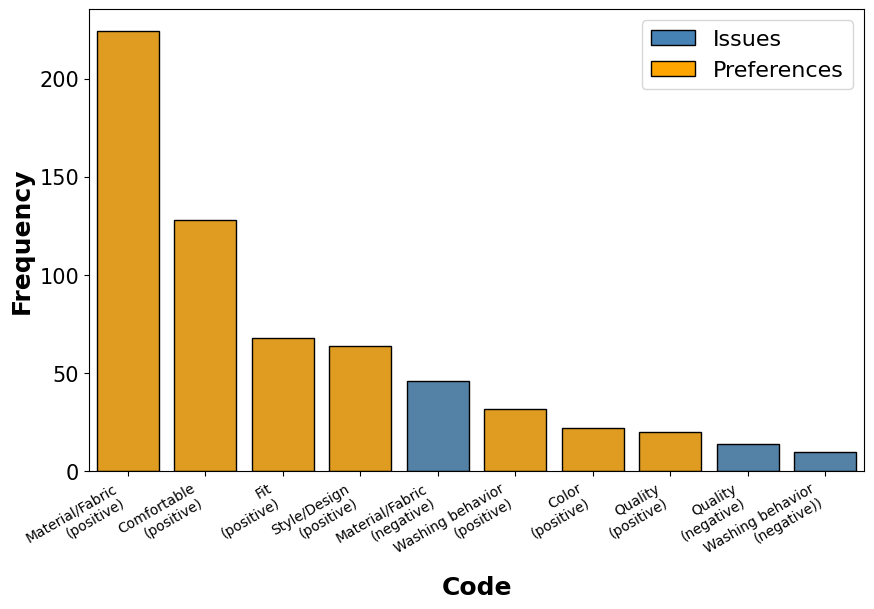

In [20]:
# Plot LLaMA 3 main categories 
plt.figure(figsize=(10, 6))
# Define custom colors using valid color names or hex codes
custom_colors = ['orange', 'orange', 'orange', 'orange', 'steelblue', 'orange', 'orange', 'orange', 'steelblue', 'steelblue']

sns_barplot = sns.barplot(x='Code', y='Frequency', data=code_frequencies_llama_topten_main, palette=custom_colors)
for bar in sns_barplot.patches:
    bar.set_edgecolor('black')  # Set the border color
    bar.set_linewidth(1)        # Set the border thickness

# Manually add custom labels to the bars
custom_labels = ['Material/Fabric\n(positive)', 'Comfortable\n(positive)', 'Fit\n(positive)', 'Style/Design\n(positive)', 'Material/Fabric\n(negative)', 'Washing behavior\n(positive)', 'Color\n(positive)', 'Quality\n(positive)', 'Quality\n(negative)', 'Washing behavior\n(negative))']
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, fontsize=10, rotation=30, ha='right')

# Add custom legend
legend_elements = [Patch(facecolor='steelblue', edgecolor='black', label='Issues'), Patch(facecolor='orange', edgecolor='black', label='Preferences')]
plt.legend(handles=legend_elements, loc='upper right', fontsize=16)

plt.xlabel('Code', weight='bold', fontsize=18)
plt.ylabel('Frequency', weight='bold', fontsize=18)
plt.yticks(fontsize=15)

# Manually adjust the layout
#plt.subplots_adjust(left=left_margin, right=right_margin, top=top_margin, bottom=bottom_margin)

plt.savefig('llama-3_main_codes.pdf', format='pdf', dpi=1500, bbox_inches='tight')
plt.show()

C:\Users\Valentin Velev\AppData\Local\Temp\ipykernel_29464\1752451965.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns_barplot = sns.barplot(x='Code', y='Frequency', data=code_frequencies_real_topten, palette=custom_colors)


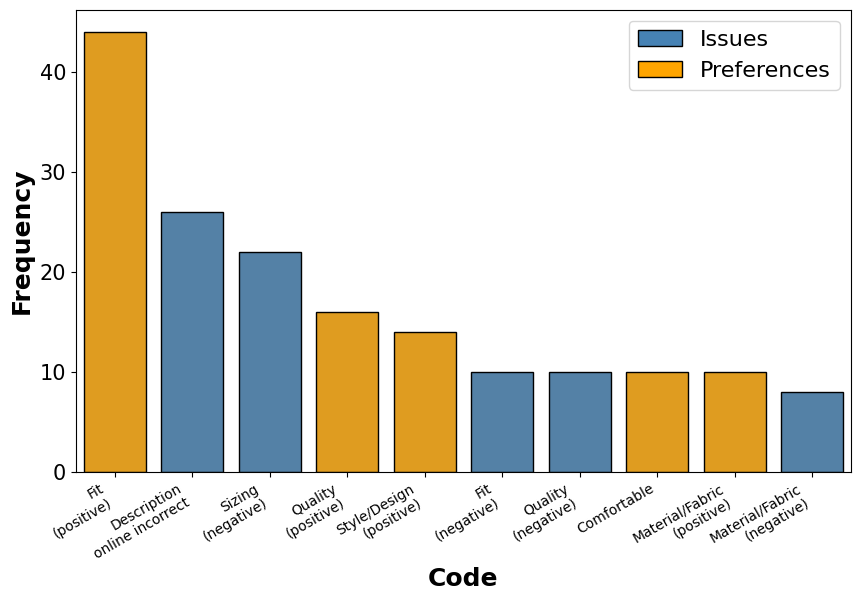

In [21]:
# Plot real reviews all categories
plt.figure(figsize=(10, 6))
# Define custom colors using valid color names or hex codes
custom_colors = ['orange', 'steelblue', 'steelblue', 'orange', 'orange', 'steelblue', 'steelblue', 'orange', 'orange', 'steelblue']

sns_barplot = sns.barplot(x='Code', y='Frequency', data=code_frequencies_real_topten, palette=custom_colors)
for bar in sns_barplot.patches:
    bar.set_edgecolor('black')  # Set the border color
    bar.set_linewidth(1)        # Set the border thickness

# Manually add custom labels to the bars
custom_labels = ['Fit\n(positive)', 'Description\nonline incorrect', 'Sizing\n(negative)', 'Quality\n(positive)', 'Style/Design\n(positive)', 'Fit\n(negative)', 'Quality\n(negative)', 'Comfortable', 'Material/Fabric\n(positive)', 'Material/Fabric\n(negative)']
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, fontsize=10, rotation=30, ha='right')

# Add custom legend
legend_elements = [Patch(facecolor='steelblue', edgecolor='black', label='Issues'), Patch(facecolor='orange', edgecolor='black', label='Preferences')]
plt.legend(handles=legend_elements, loc='upper right', fontsize=16)

plt.xlabel('Code', weight='bold', fontsize=18)
plt.ylabel('Frequency', weight='bold', fontsize=18)
plt.yticks(fontsize=15)

# Manually adjust the layout
#plt.subplots_adjust(left=left_margin, right=right_margin, top=top_margin, bottom=bottom_margin)

plt.savefig('real_all_codes.pdf', format='pdf', dpi=1500, bbox_inches='tight')
plt.show()

C:\Users\Valentin Velev\AppData\Local\Temp\ipykernel_29464\1412048691.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns_barplot = sns.barplot(x='Code', y='Frequency', data=code_frequencies_real_topten_main, palette=custom_colors)


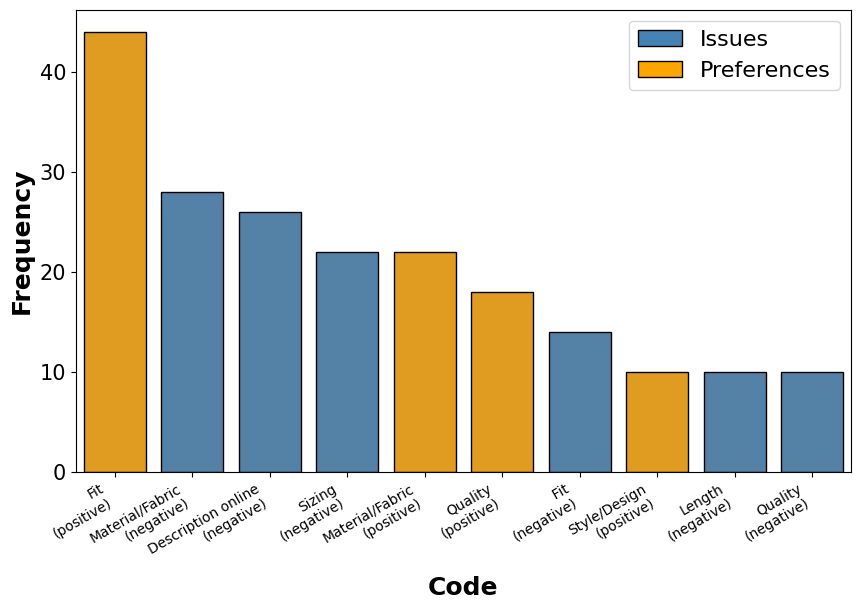

In [22]:
# Plot real reviews main categories 
plt.figure(figsize=(10, 6))
# Define custom colors using valid color names or hex codes
custom_colors = ['orange', 'steelblue', 'steelblue', 'steelblue', 'orange', 'orange', 'steelblue', 'orange', 'steelblue', 'steelblue']

sns_barplot = sns.barplot(x='Code', y='Frequency', data=code_frequencies_real_topten_main, palette=custom_colors)
for bar in sns_barplot.patches:
    bar.set_edgecolor('black')  # Set the border color
    bar.set_linewidth(1)        # Set the border thickness

# Manually add custom labels to the bars
custom_labels = ['Fit\n(positive)', 'Material/Fabric\n(negative)', 'Description online\n(negative)', 'Sizing\n(negative)', 'Material/Fabric\n(positive)', 'Quality\n(positive)', ' Fit\n(negative)', 'Style/Design\n(positive)', 'Length\n(negative)', 'Quality\n(negative)']
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, fontsize=10, rotation=30, ha='right')

# Add custom legend
legend_elements = [Patch(facecolor='steelblue', edgecolor='black', label='Issues'), Patch(facecolor='orange', edgecolor='black', label='Preferences')]
plt.legend(handles=legend_elements, loc='upper right', fontsize=16)

plt.xlabel('Code', weight='bold', fontsize=18)
plt.ylabel('Frequency', weight='bold', fontsize=18)
plt.yticks(fontsize=15)

# Manually adjust the layout
#plt.subplots_adjust(left=left_margin, right=right_margin, top=top_margin, bottom=bottom_margin)

plt.savefig('real_main_codes.pdf', format='pdf', dpi=1500, bbox_inches='tight')
plt.show()